In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate

In [2]:
df = pd.read_excel('IR.xlsx')

In [3]:
df

,Duration,Duration Type,Interest rate,Duration in year,Present Value
0,1,month,0.03385,0.083333,0.997183
1,3,months,0.03328,0.250000,0.991715
2,6,months,0.03186,0.500000,0.984196
3,9,months,0.03010,0.750000,0.977678
4,1,year,0.02819,1.000000,0.972204
5,2,years,0.02352,2.000000,0.954049
6,3,years,0.02201,3.000000,0.936103
7,4,years,0.02082,4.000000,0.920093
8,5,years,0.02088,5.000000,0.900865
9,6,years,0.02025,6.000000,0.885591


In [4]:
def P0T(T):
    df = pd.read_excel('IR.xlsx')
    ti = df['Duration in year'].values
    pv = df['Present Value'].values
    interpolator = interpolate.splrep(ti, np.log(pv), s=0.00001)
    expr = np.exp(interpolate.splev(T, interpolator, der=0))
    return expr

In [5]:
def f0T(t):
    del_t = 0.01
    P0T_1 = P0T(t+del_t)
    P0T_2 = P0T(t-del_t)
    expr = - (np.log(P0T_1) - np.log(P0T_2)) / (2*del_t)
    
    return expr

In [6]:
def GeneratePathsHWEuler(npaths, nsteps, T, lambd, sigma): #This will run after 10 years, as we have data till 10 years, then we need to forcast from 10 years to 49 years 
    r0 = f0T(0.01)
    
    def theta(t):
        term_1 = f0T(t+dt)
        term_2 = f0T(t-dt)
        term_3 = f0T(t)
        term_4 = (sigma*sigma) / (2.0*lambd*lambd)*(1 - np.exp(-2.0*lambd*t))
        expr = (1.0/lambd)*(term_1 - term_2)/(2*dt) + term_3 + term_4
        return expr
    Z = np.random.normal(0.0,1.0,[npaths,nsteps])
    W = np.zeros([npaths, nsteps+1])
    R = np.zeros([npaths, nsteps+1])
    M = np.zeros([npaths, nsteps+1])
    M[:,0] = 1.0
    R[:,0] = r0
    time = np.zeros([nsteps+1])
    dt = T / nsteps
    
    for i in range(0,nsteps):
        if npaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i])*dt + sigma*(W[:,i+1]-W[:,i])
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1] + R[:,i])*0.5*dt)
        time[i+1] = time[i] + dt
        
    paths = {'time':time, 'R': R, 'M':M}
    
    return paths 

In [7]:
def HW_A(lambd,sigma,T1,T2):
    tau = T2 - T1
    zGrid = np.linspace(0.0, tau, 250)
    def B_r(tau_val):
        return (1.0/lambd) * (np.exp(-lambd*tau_val) - 1.0)
    
    def theta(t):
        dt = 0.01
        term_1 = f0T(t+dt)
        term_2 = f0T(t-dt)
        term_3 = f0T(t)
        term_4 = (sigma*sigma) / (2.0*lambd*lambd)*(1 - np.exp(-2.0*lambd*t))
        expr = (1.0/lambd)*(term_1 - term_2)/(2*dt) + term_3 + term_4
        return expr
    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid), zGrid)
    temp2 = (sigma**2)/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) - 3.0) + (sigma*sigma*tau)/(2.0*lambd*lambd)
    
    return temp1 + temp2

In [8]:
def HW_B(lambd, sigma, T1, T2):
    return (1.0/lambd) * (np.exp(-lambd*(T2-T1)) - 1.0)

In [9]:
def HW_ZCB(lambd, sigma, T1, T2, rT1):
    B_r = HW_B(lambd, sigma, T1, T2)
    A_r = HW_A(lambd, sigma, T1, T2)
    
    return np.exp(A_r + B_r*rT1)

In [10]:
mpl.rcParams['figure.figsize'] = (14,12)

In [11]:
def finalCalculation():
    npaths = 2000
    nsteps = 100
    lambd = 0.001
    sigma = 0.003
    
    r0 = f0T(0.01)
    N = 30
    T_end0 = 30.0
    Tgrid = np.linspace(0.1, T_end0, N)
    Exact = np.zeros([N,1]) #20,1
    Proxy_1FHW = np.zeros([N,1]) #20,1
    Yield = np.zeros([N,1]) #20,1
    for i, Ti in enumerate(Tgrid):
        Proxy_1FHW[i] = HW_ZCB(lambd, sigma, 0.0, Ti, r0) # generate 20 results each for 1 loop run, with first value of r0
        Exact[i] = P0T(Ti)
        Yield[i] = -np.log(Proxy_1FHW[i])/Ti
    #print(Yield)
    mpl.rcParams['figure.figsize'] = (10,8)
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid, Yield, '-k')
    plt.xlabel('T')
    plt.ylabel('Yield, r(0,T)')
    
    T_end = 30
    
    paths = GeneratePathsHWEuler(npaths,nsteps,T_end,lambd,sigma)
    
    r = paths['R']
    timeGrid = paths['time']
    mpl.rcParams['figure.figsize'] = (10,8)
    plt.figure(2)
    for i in range(0,100):
        plt.plot(timeGrid,r[i,:])
    plt.show()
    mpl.rcParams['figure.figsize'] = (10,8)
    plt.figure(3)
    plt.xlabel('time')
    plt.ylabel('r(t)')
    plt.title('MC Paths + Yield Curve (Hull-White)')
    plt.grid()
    
    T_end2 = T_end + N
    Tgrid2 = np.linspace(T_end+0.01, T_end2-0.01,N)
    ZCB = np.zeros([N,1])
    r_T = r[:,-1]
    
    for i in range(0,N):
        for j,Tj in enumerate(Tgrid2):
            ZCB[j] = HW_ZCB(lambd,sigma,T_end,Tj,r_T[i])
            Yield[j] = -np.log(ZCB[j])/(Tj-T_end)
        
        plt.plot(Tgrid2, Yield)
        plt.plot(timeGrid,r[i,:])
    
    return r

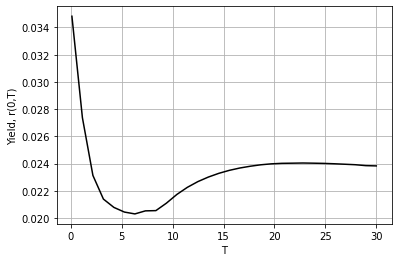

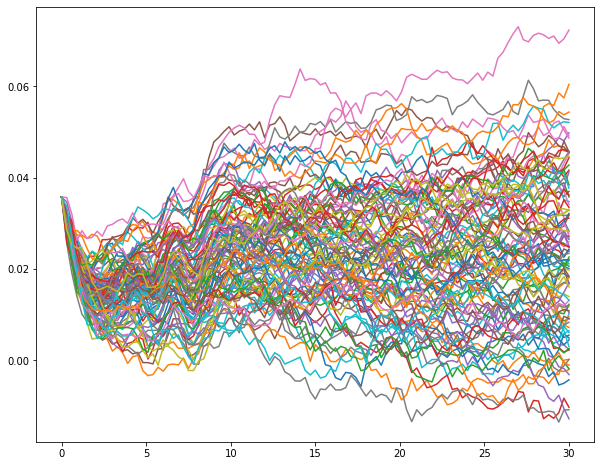

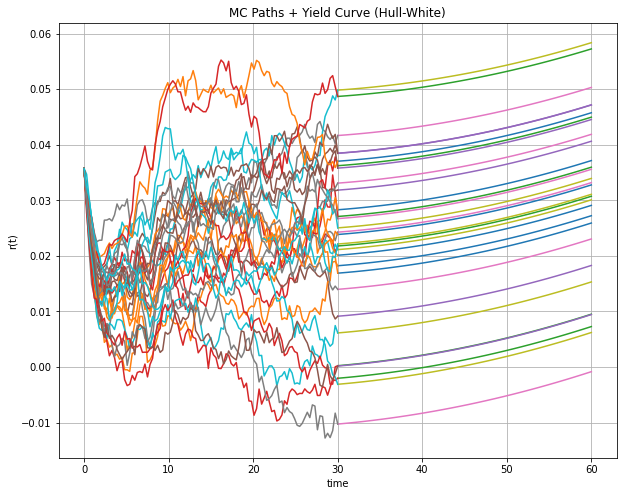

In [12]:
rate = finalCalculation()

In [14]:
rate[:,-1].mean(), rate[:,-1].std()

(0.02388881114395072, 0.016430860475324167)